<a href="https://colab.research.google.com/github/namjad381/Machine-Learning-AMD-project/blob/main/Sentiment_Analysis_Covaxin_tweets_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
!pip install neattext

     |████████████████████████████████| 114 kB 36.7 MB/s 


In [48]:
#Import Libraries 

import tweepy
import json
import time
import datetime
import os
import itertools
import os
import csv
import pandas as pd
import numpy as np
from scipy.sparse import vstack, hstack
from scipy.sparse import csr_matrix
import re
from string import digits
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from gensim.models.phrases import Phrases

from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import neattext.functions as nfx
% matplotlib inline

In [ ]:
#Api credentials
consumer_key = "JYGzzjhuiUoI4W6j0lj9i1lCx"
consumer_secret = "p00uHIuFeQPLGfzu0uYDTzcXumeCrpmxdkn8xPvqDh1GtI1lXT"
access_token_key = "1218878730405322752-X7c55wLQ2WJCIGGpVhvy7Vild3towe"
access_token_secret = "XV4j2sjf4aEIjKgKfxIELeQcEXeuElLNm3D4h4QRnS4w4"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token_key, access_token_secret)
api  = tweepy.API(auth)

In [ ]:
if api.me():
    print("Authenticated\n")
else:
    print("Error in Authentication\n")

# Download tweets by hashtag

In [ ]:
path_out = "C:/Users/admin/Desktop/df_tweets_" + str(datetime.date.today()) + '.csv'


hashtag_list_en = ["#covaxin", "#COVIDVaccination", "#COVAXIN", "#Covid-19#vaccine", "#vaccinated", "#getvaxxed", "#pfizer", "#AstraZeneca", "#vaccination", "#Moderna", "#LetsGetShots", "#fullyvaxxed", "#GetVaccinatedNow", "#VaccinesWork", "#firstdose", "#seconddose", "#vaccinationhesitancy", "#SARSCoV2", "#deltavarient", "#coronavirusvarient", "#b117"]

In [ ]:

no_retweet   = " -filter:retweets"
language     = ["en", "it"]
today        = datetime.date.today().strftime("%Y-%m-%d")
period       = " until:" + today


In [ ]:
flag_header = True

if flag_header == True:
    with open(path_out, "w") as o:
        o.write("hashtag|timestamp|tweet_text|user_name|language\n") # solo una volta al giorno

        flag_header = False

In [ ]:
counter = 0
times   = 0

while times <= 100: # inserire un numero piu' grande

    for lang in language:

        if lang == "en":
            hashtag_list = hashtag_list_en
        else:
            hashtag_list = hashtag_list_it

        for hash in hashtag_list:

            query = hash + no_retweet + period + " lang:" + lang

            try:

                for page in tweepy.Cursor(api.search, q=query, tweet_mode = "extended").pages():
                    for status in page:

                        try:
                            full_text = status.full_text.replace("\n", " ").replace("|", "").encode("utf-8").decode("ascii", "ignore")
                            url_to_rm = re.search("(?P<url>https?://[^\s].+)", full_text).group("url") # cerca https in tweet

                            text      = full_text.replace(url_to_rm, "").strip().replace("  ", " ") # toglie https in tweet
                            time_data = str(status.created_at)
                            user_name = status.user.screen_name
                            # print str(counter) + " : " + text
                            counter += 1
                            print(str(counter), ":", hash)
                        except:

                            text      = status.full_text.replace("\n", " ").replace("|", "").encode("utf-8").decode("ascii", "ignore").strip().replace("  ", " ")
                            time_data = str(status.created_at)
                            user_name = status.user.screen_name
                            # print str(counter) + " : " + text
                            counter += 1
                            print(str(counter), ":", hash)

                        raw_line = str(hash + "|" + time_data + "|" + text + "|" + user_name + "|" + lang)

                        with open(path_out, "a") as o:
                            o.write(raw_line + '\n')

                        # print(str(counter))
                        time.sleep(0.1)

            except Exception as e:
                print(e)
                print("\n\nSuperato il limite, aspetto 15 minuti")

                time.sleep(15 * 60 + 1)

    times += 1

# Preprocessing tweet's text

In [7]:

path_in_our_tweets         = "/content/drive/MyDrive/Thesis Sentiment Analaysis /All_tweets.csv"


In [8]:
df                         = pd.read_csv(path_in_our_tweets, lineterminator='\n', sep = "|", header= 0, error_bad_lines=False)
df                         = df.drop_duplicates(subset="tweet_text") 
df = df.rename(columns={'language\r': 'language'})
df.columns

Index(['hashtag', 'timestamp', 'tweet_text', 'user_name', 'language'], dtype='object')

In [9]:
df.shape

(471611, 5)

In [10]:
df = df.replace("en\r", "en")
df = df.replace("en,,,,,,,,,,,,,,,,,,,,,,,\r", "en")
df = df.replace("en,,,,,,,,,,,,,,,,,,,,,,,", "en")
df = df.replace("en,,,,,,,,,,,,,,,,,,,,", "en")
df = df.replace("it,,,,,,,,,,,,,,,,,,,,,,", "it")
df = df.replace("it,,,,,,,,,,,,,,,,,,,,,", "it")
df = df.replace("it,,,,,,,,,,,,,,,,,,,,,,,", "it")
df.dropna()
df.sample(20)

,hashtag,timestamp,tweet_text,user_name,language
3688745,#vaccination,2021-09-05 08:45:07,Where tf is the 14 million #Pfizer vaccines? @...,romato_17,en
1131477,#COVID19,2021-10-16 17:45:37,The #COVID19 pandemic has been especially toug...,medical_relief,en
354018,#COVIDVaccination,2021-09-29 04:16:37,Now that #COVIDVaccination are mandatory who w...,Redstarpro,en
1246918,#COVID19,2021-10-20 20:50:36,Good God @simon_ball46 Remember when @RealDona...,SwerianBot,en
3061465,#vaccination,2021-08-15 19:26:06,Mandates requiring proof of vaccination have t...,albertfong98,en
3814012,#coronavirus,2021-09-09 11:47:17,New article: Characterization of epidemiologic...,PaperbirdsH,en
3194495,#vaccination,2021-08-18 12:46:32,Cats vs Cucumbers Reaction,_Funny_Cute_,en
4025387,#vaccinated,2021-09-15 10:02:51,Listen to this outrageous explanation of why #...,TrueNewsCo,en
3939009,#GetVaccinatedNow,2021-09-12 12:22:24,@jrhodes911 @drdagly Then they should be in fr...,peggyturni,en
2954954,#getvaxxed,2021-08-10 01:23:56,That mashed-potato pizza and a toasted blonde ...,Matt_Blumenthal,en


In [11]:
df.user_name.describe()

count             471611
unique            160614
top       cowinblore1844
freq                9149
Name: user_name, dtype: object

In [12]:
df.groupby('hashtag').describe()

timestamp         ...    language       
                                   count unique  ...         top   freq
hashtag                                          ...                   
# #AstraZeneca                        48     48  ...          en     48
#AstraZeneca                        9732   9720  ...          en   9732
#COVAXIN                            4057   4040  ...          en   4057
#COVID19                           62656  56658  ...          en  62656
#COVID19Vaccine                     9006   8233  ...          en   9006
#COVID19Vic                        15706  15554  ...          en  15706
#COVIDIDIOTS                        1670   1670  ...          en   1670
#COVIDIOT                           1251   1250  ...          en   1251
#COVIDVaccination                  22289  20671  ...          en  22289
#Covid-19                           3405   2558  ...          en   3405
#Covid-19#vaccine                   9559   9474  ...          en   9559
#Covid-19#vaccine, #vaccinated       277    277  ...          en    277
#DeltaVariant                       5705   5698  ...          en   5705
#GetVaccinatedNow                  46339  45956  ...          en  46339
#LetsGetShots                          4      4  ...          en      4
#LockdownNow                          12     12  ...          en     12
#Moderna                           16292  16229  ...          en  16292
#SARSCoV2                          20688  20537  ...          en  20688
#SocialDistancing                   1448   1440  ...          en   1448
#VaccineSideEffects                 8315   8306  ...          en   8315
#VaccinesWork                      39763  39553  ...          en  39763
#b117                                 37     37  ...          en     37
#coronavirus                        5692   5531  ...          en   5692
#covaxin                           33307  32861  ...          en  33307
#covid19recovery                     240    231  ...          en    240
#deltavarient                         95     93  ...          en     95
#firstdose                           294    294  ...          en    294
#fullyvaxxed                        2069   2067  ...          en   2069
#getvaxxed                         20191  20143  ...          en  20191
#pfizer                            38803  38564  ...          en  38803
#seconddose                          376    376  ...          en    376
#vaccinated                        42991  42652  ...          en  42991
#vaccination                       49277  48908  ...          en  49277
#vaccinationhesitancy                 16     16  ...          en     16
hashtag                                1      1  ...  language\r      1

[35 rows x 16 columns]

In [13]:

df = df.drop(df[df["timestamp"] =="legionarionero"].index)
df = df.drop(df[df["timestamp"] =="tobiazevi"].index)
df = df.drop(df[df["timestamp"] =="DanielaPF75"].index)
df = df.drop(df[df["timestamp"] =="siamonoitv2000"].index)
df = df.drop(df[df["timestamp"] =="PaoloBrandi"].index)
df = df.drop(df[df["timestamp"] == "JacopoLancioni1"].index)
df = df.drop(df[df["timestamp"] =="il_Giangi"].index)
df = df.drop(df[df["timestamp"] =="Crit_Social_Sci"].index)
df = df.drop(df[df["timestamp"] =="YummyTaterTots"].index)
df = df.drop(df[df["timestamp"] =="FrancisWasHere"].index)
df = df.drop(df[df["timestamp"] =="	EthanBearman"].index)
df = df.drop(df[df["timestamp"] =="MediciVendetta"].index)
df = df.drop(df[df["timestamp"] =="GrumpyOldAstro"].index)
df = df.drop(df[df["timestamp"] =="MarkWhittier1"].index)
df = df.drop(df[df["timestamp"] =="_Savage_Mom_"].index)
df = df.drop(df[df["timestamp"] =="JoyGrenade"].index)
df = df.drop(df[df["timestamp"] =="iref_ricerche"].index)
df = df.drop(df[df["timestamp"] =="NICOLACATAR"].index)
df = df.drop(df[df["timestamp"] =="wlybrand"].index)
df = df.dropna()

In [14]:
df.groupby('hashtag').describe()

timestamp         ...    language       
                                   count unique  ...         top   freq
hashtag                                          ...                   
# #AstraZeneca                        48     48  ...          en     48
#AstraZeneca                        9732   9720  ...          en   9732
#COVAXIN                            4057   4040  ...          en   4057
#COVID19                           62656  56658  ...          en  62656
#COVID19Vaccine                     9006   8233  ...          en   9006
#COVID19Vic                        15706  15554  ...          en  15706
#COVIDIDIOTS                        1670   1670  ...          en   1670
#COVIDIOT                           1251   1250  ...          en   1251
#COVIDVaccination                  22289  20671  ...          en  22289
#Covid-19                           3405   2558  ...          en   3405
#Covid-19#vaccine                   9559   9474  ...          en   9559
#Covid-19#vaccine, #vaccinated       277    277  ...          en    277
#DeltaVariant                       5705   5698  ...          en   5705
#GetVaccinatedNow                  46339  45956  ...          en  46339
#LetsGetShots                          4      4  ...          en      4
#LockdownNow                          12     12  ...          en     12
#Moderna                           16292  16229  ...          en  16292
#SARSCoV2                          20688  20537  ...          en  20688
#SocialDistancing                   1448   1440  ...          en   1448
#VaccineSideEffects                 8315   8306  ...          en   8315
#VaccinesWork                      39763  39553  ...          en  39763
#b117                                 37     37  ...          en     37
#coronavirus                        5692   5531  ...          en   5692
#covaxin                           33306  32860  ...          en  33306
#covid19recovery                     240    231  ...          en    240
#deltavarient                         95     93  ...          en     95
#firstdose                           294    294  ...          en    294
#fullyvaxxed                        2069   2067  ...          en   2069
#getvaxxed                         20191  20143  ...          en  20191
#pfizer                            38803  38564  ...          en  38803
#seconddose                          376    376  ...          en    376
#vaccinated                        42991  42652  ...          en  42991
#vaccination                       49277  48908  ...          en  49277
#vaccinationhesitancy                 16     16  ...          en     16
hashtag                                1      1  ...  language\r      1

[35 rows x 16 columns]

In [15]:
df.head()

,hashtag,timestamp,tweet_text,user_name,language
0,#covaxin,2021-09-20 23:45:32,It would be a travesty of @pfizer is granted E...,gottosayit,en
1,#covaxin,2021-09-20 23:11:18,180cr #Vaccination by December..90% adults wil...,bannurjy,en
2,#covaxin,2021-09-20 22:35:32,"@GHS @mvankerkhove We also need to ask @WHO , ...",bert070784,en
3,#covaxin,2021-09-20 21:12:24,182 hedges in one stock should speak volumes y...,michaelcoleufc2,en
4,#covaxin,2021-09-20 20:45:36,Institutional Buyers = 182 $OCGN #COVAXIN #Ocu...,Xukki2,en


In [16]:
df.tail()

,hashtag,timestamp,tweet_text,user_name,language
4119696,#VaccinesWork,2021-09-14 12:54:41,Why must one of our vaccinated Veterans have t...,DebeeMI,en
4120026,#SARSCoV2,2021-09-17 22:57:59,@MaddyLoveSpare eventhough the jab isnt a cure...,WorldOfMarkyD,en
4120031,#SARSCoV2,2021-09-17 22:34:49,"and if authorities refuse to say, which medica...",WorldOfMarkyD,en
4120032,#SARSCoV2,2021-09-17 22:30:43,since authorities are condemning people to cat...,WorldOfMarkyD,en
4122303,#SARSCoV2,2021-09-10 14:49:31,@Greg_Palast u who stand for justice? U who fi...,kanarsevon,en


In [17]:
del df['user_name']

In [18]:
del df['language']

In [19]:
df['id'] = [str(id) for id in list(range(df.shape[0]))]

In [20]:
df['tweet_text']

0          It would be a travesty of @pfizer is granted E...
1          180cr #Vaccination by December..90% adults wil...
2          @GHS @mvankerkhove We also need to ask @WHO , ...
3          182 hedges in one stock should speak volumes y...
4          Institutional Buyers = 182 $OCGN #COVAXIN #Ocu...
                                 ...                        
4119696    Why must one of our vaccinated Veterans have t...
4120026    @MaddyLoveSpare eventhough the jab isnt a cure...
4120031    and if authorities refuse to say, which medica...
4120032    since authorities are condemning people to cat...
4122303    @Greg_Palast u who stand for justice? U who fi...
Name: tweet_text, Length: 471610, dtype: object

In [21]:
#clean tweets

def cleanText(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text) #remove mentioned
  text = re.sub(r'#', '', text) #remove hash symbol
  text = re.sub(r'RT[\S]+', '', text) #remove RT
  text = re.sub(r'http?:\/\/\S+', '', text) #removethe hyper link
  text = re.sub(r'(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?', '', text)

  return text

In [22]:
df['tweet_text'] = df['tweet_text'].apply(cleanText)


In [23]:
#remove numbers
df['tweet_text'] = df['tweet_text'].str.replace('\d+', '')

In [24]:
df['tweet_text'] 

0          It would be a travesty of  is granted EUA for ...
1          cr Vaccination by December adults will have do...
2            We also need to ask   FDA and  to expedite a...
3           hedges in one stock should speak volumes yet ...
4          Institutional Buyers   OCGN COVAXIN Ocugen Bha...
                                 ...                        
4119696    Why must one of our vaccinated Veterans have t...
4120026     eventhough the jab isnt a cure it doesnt prev...
4120031    and if authorities refuse to say which medicat...
4120032    since authorities are condemning people to cat...
4122303    Palast u who stand for justice U who fight dis...
Name: tweet_text, Length: 471610, dtype: object

In [25]:
df['tweet_text'].tail(5)

4119696    Why must one of our vaccinated Veterans have t...
4120026     eventhough the jab isnt a cure it doesnt prev...
4120031    and if authorities refuse to say which medicat...
4120032    since authorities are condemning people to cat...
4122303    Palast u who stand for justice U who fight dis...
Name: tweet_text, dtype: object

# **Sentiment Analysis**

In [26]:
#function to get subjectivity

def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

#function to get polarity

def getPolarity(text):
  return TextBlob(text).sentiment.polarity

#create two new columns

df['polarity'] = df['tweet_text'].apply(getPolarity)
df['subjectivity'] = df['tweet_text'].apply(getSubjectivity)





In [27]:
#get pos, neg, neu 

def getAnalysis(score):
  if score < 0:
    return 'Negative'
  if score == 0:
    return 'Neutral'
  else:
    return 'Positive'

df['Sentiments'] = df['polarity'].apply(getAnalysis)
df

,hashtag,timestamp,tweet_text,id,polarity,subjectivity,Sentiments
0,#covaxin,2021-09-20 23:45:32,It would be a travesty of is granted EUA for ...,0,0.025000,0.2875,Positive
1,#covaxin,2021-09-20 23:11:18,cr Vaccination by December adults will have do...,1,0.000000,0.0000,Neutral
2,#covaxin,2021-09-20 22:35:32,We also need to ask FDA and to expedite a...,2,0.187500,0.4375,Positive
3,#covaxin,2021-09-20 21:12:24,hedges in one stock should speak volumes yet ...,3,0.600000,1.0000,Positive
4,#covaxin,2021-09-20 20:45:36,Institutional Buyers OCGN COVAXIN Ocugen Bha...,4,0.000000,0.0000,Neutral
...,...,...,...,...,...,...,...
4119696,#VaccinesWork,2021-09-14 12:54:41,Why must one of our vaccinated Veterans have t...,471605,0.000000,0.0000,Neutral
4120026,#SARSCoV2,2021-09-17 22:57:59,eventhough the jab isnt a cure it doesnt prev...,471606,0.000000,0.1000,Neutral
4120031,#SARSCoV2,2021-09-17 22:34:49,and if authorities refuse to say which medicat...,471607,-0.183333,0.5500,Negative
4120032,#SARSCoV2,2021-09-17 22:30:43,since authorities are condemning people to cat...,471608,0.000000,0.0000,Neutral


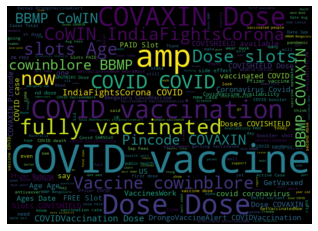

In [28]:
#plot the word cloud

allwords = ' '.join( [twts for twts in df['tweet_text']] )

wordCloud = WordCloud(width = 700, height=500, random_state = 21, max_font_size = 130).generate(allwords)

plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

In [29]:
df['Sentiments'].value_counts()

Positive    222255
Neutral     164157
Negative     85198
Name: Sentiments, dtype: int64

In [30]:
#get neutral %

neutweets = df[df.Sentiments == 'Neutral']
neutweets = neutweets['tweet_text']

round( (neutweets.shape[0] / df.shape[0]) *100 , 1 )

34.8

In [31]:
#get Positive %
postweets = df[df.Sentiments == 'Positive']
postweets = postweets['tweet_text']

round( (postweets.shape[0] / df.shape[0]) *100 , 1 )

47.1

In [32]:
#get Negative %
negtweets = df[df.Sentiments == 'Negative']
negtweets = negtweets['tweet_text']

round( (negtweets.shape[0] / df.shape[0]) *100 , 1 )

18.1

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Sentiment Analysis bar plot')

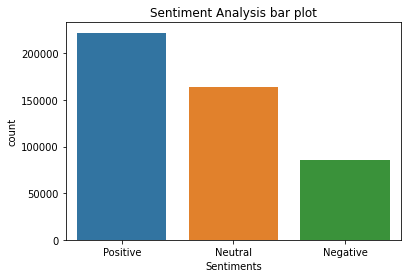

In [33]:
#plot % chart

sns.countplot(df['Sentiments'])
plt.title('Sentiment Analysis bar plot')

In [35]:
Positive_tweet = df[df['Sentiments'] == 'Positive']['tweet_text']

In [50]:
Negative_tweet = df[df['Sentiments'] == 'Negative']['tweet_text']
Neutral_tweet = df[df['Sentiments'] == 'Neutral']['tweet_text']

In [51]:
Positive_tweet

0          It would be a travesty of  is granted EUA for ...
2            We also need to ask   FDA and  to expedite a...
3           hedges in one stock should speak volumes yet ...
5           Unfollowed you for your Over Action with no h...
8           I bet most are just impatiently awaiting appr...
                                 ...                        
4117135     Fox not news its entertainment like cartoons ...
4117207    Today I got my Moderna booster and my flu shot...
4117532    Medical experts are researching how COVID vacc...
4118542    If its safe the manufacturers will have no pro...
4118647    I am worth it FullyVaccinated GetVaccinated Va...
Name: tweet_text, Length: 222255, dtype: object

In [52]:
# Remove Stopwords and Convert to Tokens
Positive_tweet_list = Positive_tweet.apply(nfx.remove_stopwords).tolist()
Negative_tweet_list = Negative_tweet.apply(nfx.remove_stopwords).tolist()
Neutral_tweet_list = Neutral_tweet.apply(nfx.remove_stopwords).tolist()

In [53]:
Positive_tweet_list

['travesty granted EUA despite denied Big pharma power suppressing efficient vaccine amp globally influencing borderline criminal lives stake COVAXIN',
 'need ask FDA expedite approval COVAXIN distribute vaccines countries solution avoid people dying Lets heal world COVAXIN',
 'hedges stock speak volumes yall stay sidelines chase lmao ocgn FDA covaxin deltavariantkiller',
 'Unfollowed Action home work COVAXIN needs approval India voluntary India vaccine chose Mfrs accountable regulators Defamation home work FoS',
 'bet impatiently awaiting approval Long overdue covaxin',
 'FDA prefer Covaxin wholy inactivated viron non mRNA vaccin higher efficacy Pfizer Moderna heart inflammation blood clots Covaxin CovidVaccine',
 'Clearly feeling insecure best healthcare systems world India time delaying Covaxin approval time appears scheme west UK deserves tit tat UKVaccineRacism COVID',
 'FREE Pincode COVAXIN Dose slots Age Ages Date Sep Fees Free Yelahanka Ambedkar Bhavan C Yelahanka BBMP CoWIN In

In [54]:

# Tokenization
for line in Positive_tweet_list:
#     print(line)
    for token in line.split():
        print(token)

Streaming output truncated to the last 5000 lines.
PM
ji
sure
PM
tears
joy
record
break
corona
vaccination
india
JaiHind
Happy
birthday
god
blesses
healthy
long
life
serve
nation
City
Manager
Edward
Augustus
Jr
Effective
masks
required
indoor
public
amp
private
common
spaces
supermarkets
restaurants
bars
regardless
vaccination
status
socialdistancing
requirement
time
MaskMandates
afternoon
amp
viral
sensation
Drew
Comments
joining
provide
info
vaccination
loving
chat
goal
educate
amp
empower
questions
fence
great
news
lka
Successful
vaccination
drive
daily
COVIDSL
cases
decreasing
success
continue
SriLanka
R
LKA
lka
GR
StaySafe
SaveLives
Heart
wcaregivers
trying
amp
patient
safe
today
esp
people
taking
key
step
zero
harmvaccination
change
think
amp
evidence
recommit
zeroharm
far
COVID
crore
vaccination
India
th
September
world
record
NarendraModi
HappyBirthdayModiji
Salute
Indian
health
workers
possible
Hope
hostess
OK
Violence
answer
COVID
vaccination
dispute
separate
note
wonder
reac

In [55]:
pos_tokens = [token for line in Positive_tweet_list  for token in line.split()]

In [56]:
neg_tokens = [token for line in Negative_tweet_list  for token in line.split()]
neut_tokens = [token for line in Neutral_tweet_list  for token in line.split()]

In [57]:
# Get Most Commonest Keywords
from collections import Counter

In [58]:
def get_tokens(docx,num=30):
    word_tokens = Counter(docx)
    most_common = word_tokens.most_common(num)
    result = dict(most_common)
    return result

In [59]:
get_tokens(pos_tokens)

{'COVAXIN': 14661,
 'COVID': 77689,
 'COVIDVaccination': 13541,
 'COVISHIELD': 14973,
 'Covid': 32123,
 'CovidVaccine': 9595,
 'Dose': 37508,
 'Doses': 8826,
 'DrongoVaccineAlert': 8458,
 'GetVaccinatedNow': 20342,
 'Moderna': 11116,
 'Pfizer': 22202,
 'SARSCoV': 10437,
 'Slots': 11116,
 'Total': 8422,
 'VaccinesWork': 18306,
 'amp': 29807,
 'available': 15368,
 'cases': 13057,
 'coronavirus': 9423,
 'covid': 16880,
 'dose': 11264,
 'health': 9500,
 'like': 8385,
 'new': 14684,
 'people': 21242,
 'vaccinated': 37511,
 'vaccination': 28805,
 'vaccine': 40190,
 'vaccines': 13858}

In [60]:
most_common_pos_words = get_tokens(pos_tokens)
most_common_neg_words = get_tokens(neg_tokens)
most_common_neut_words = get_tokens(neut_tokens)

In [61]:
# Plot with seaborn
neg_df = pd.DataFrame(most_common_neg_words.items(),columns=['words','scores'])

In [62]:
neg_df

,words,scores
0,COVID,28482
1,vaccinated,15471
2,vaccine,14051
3,amp,11976
4,GetVaccinatedNow,11780
5,Covid,10694
6,people,10642
7,vaccination,9957
8,Pfizer,8027
9,VaccinesWork,7566


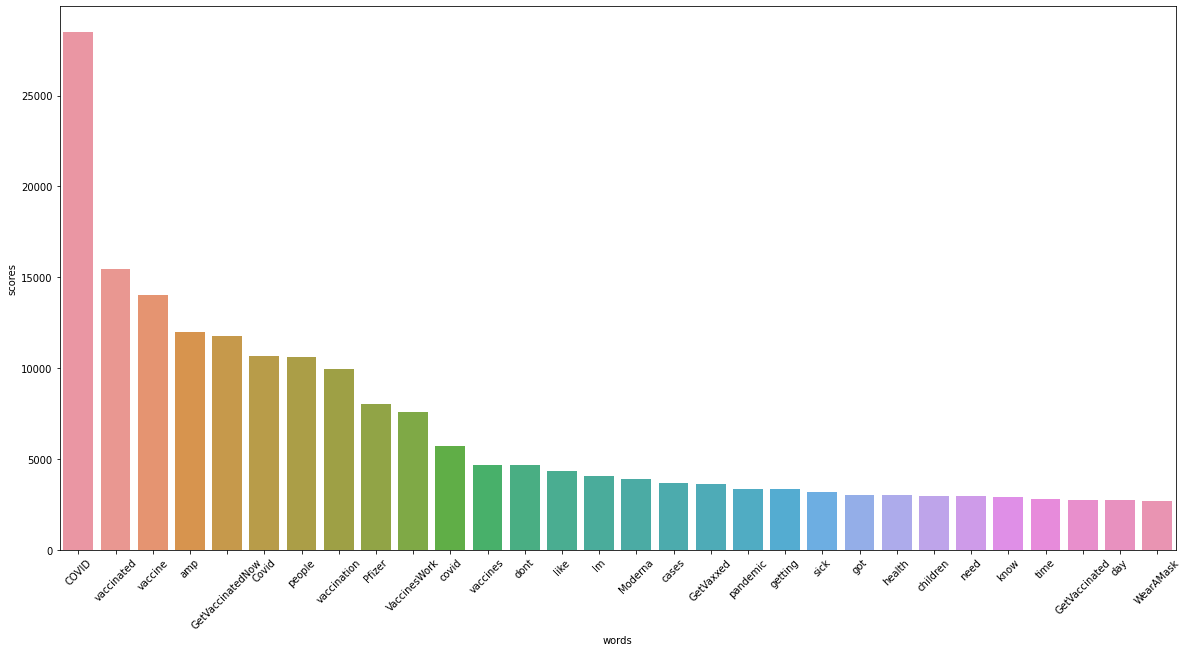

In [63]:
plt.figure(figsize=(20,10))
sns.barplot(x='words',y='scores',data=neg_df)
plt.xticks(rotation=45)
plt.show()

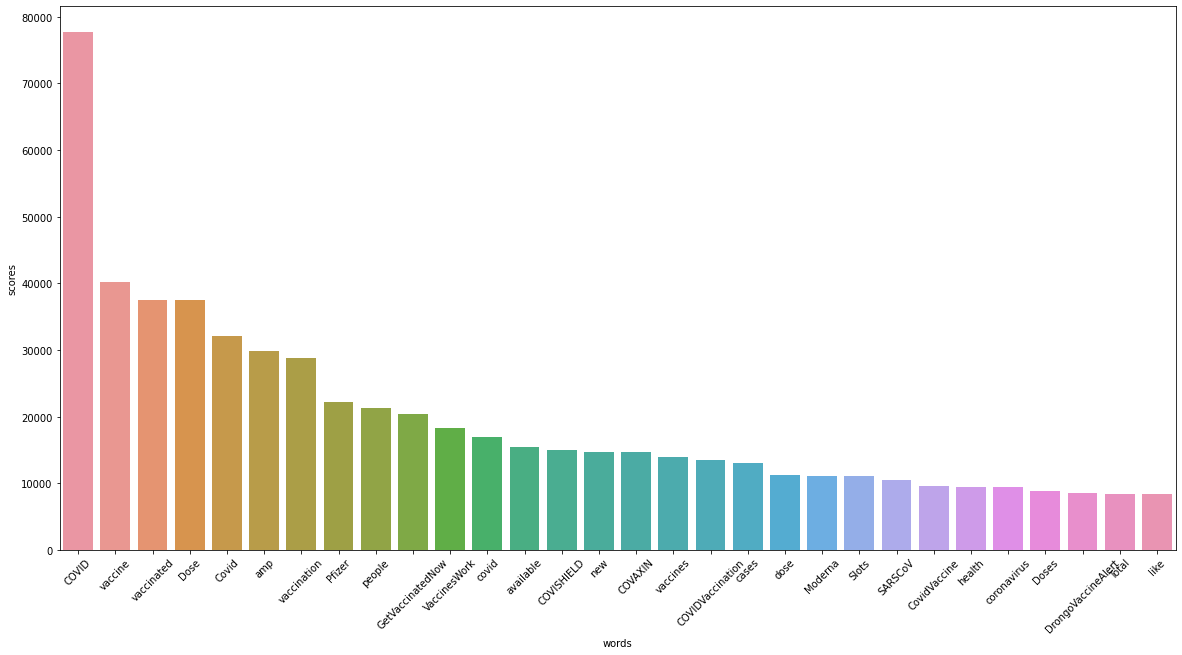

In [64]:
# Plot with seaborn
pos_df = pd.DataFrame(most_common_pos_words.items(),columns=['words','scores'])
plt.figure(figsize=(20,10))
sns.barplot(x='words',y='scores',data=pos_df)
plt.xticks(rotation=45)
plt.show()

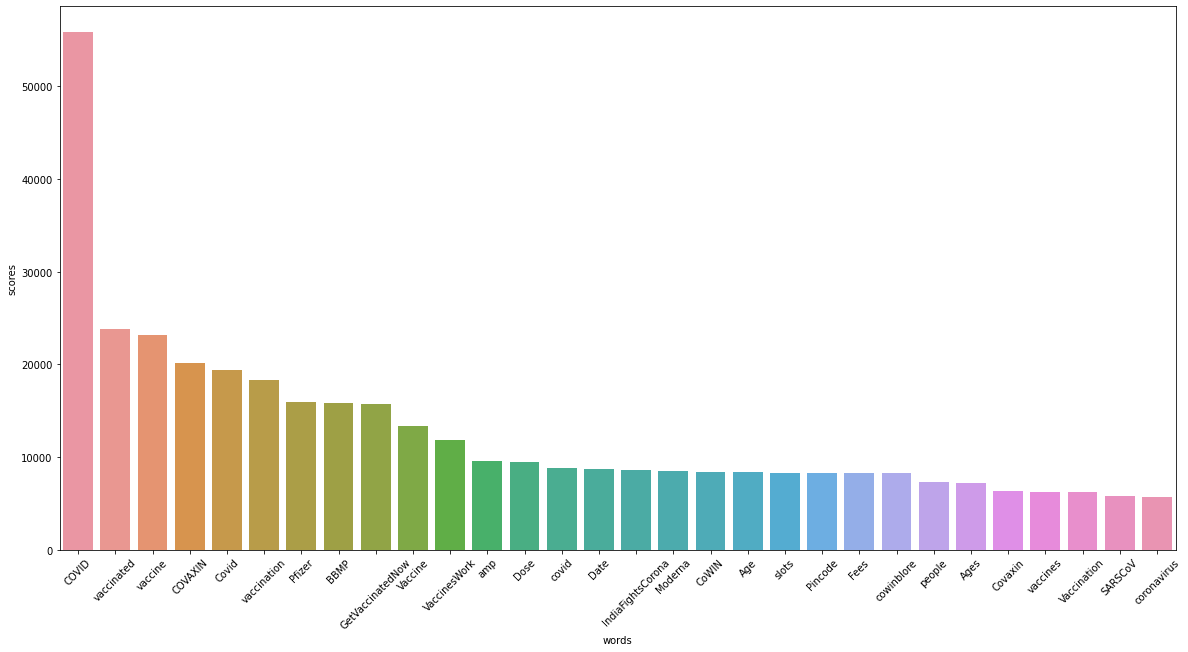

In [65]:

# Plot with seaborn
neut_df = pd.DataFrame(most_common_neut_words.items(),columns=['words','scores'])
plt.figure(figsize=(20,10))
sns.barplot(x='words',y='scores',data=neut_df)
plt.xticks(rotation=45)
plt.show()